<a href="https://colab.research.google.com/github/sprince0031/CS4445-AI-Practice/blob/staging/Week-6_Noise-and-Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 6 Exercise: Noise Handling & Regularization**

Welcome to **Week 6**! We’re focusing on **noise handling** and **regularization** techniques. This exercise demonstrates:

1. **Data Augmentation** (random crops, flips) to handle noise / robustify training.  
2. **Dropout** in a small CNN architecture.  
3. **Weight Decay** (L2 regularization) in the optimiser.

We’ll use **CIFAR-10** (10 classes: airplane, car, bird, cat, etc.), a moderate-sized dataset of 32×32 color images. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## 1. Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()


## 2. Load & Augment CIFAR-10

**Task**:  
1. Use **transforms** for data augmentation: random crop, horizontal flip.  
2. Convert to `Tensor`, normalize.  
3. Create `DataLoader` for train/test sets.

In [3]:
def getTransforms(augmentation=False):
    # mean,std for CIFAR10
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])

    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),  # basic data aug
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(cifar_mean, cifar_std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform

In [4]:
def load_cifar10_data(batch_size=64, augmentation=False):
    """
    1. define train_transform with random crop, flip, normalization
    2. define test_transform with just resize or basic normalization
    3. load CIFAR10 train/test
    4. create DataLoader for each
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: set download=True if first time
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_cifar10_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

100%|██████████| 170M/170M [00:08<00:00, 19.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train set size: 50000
Test set size: 10000


## 3. Define a CNN with Dropout

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maybe pool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetCIFAR`.

In [5]:
class NetCIFAR(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # example architecture
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)

        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128*8*8, 256)  # after 2 pools => 8x8 size
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # (batch,128,8,8)

        x = x.view(x.size(0), -1)  # flatten => (batch, 128*8*8)
        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.fc1(x))
        if self.useRegularization:
            x = self.dropout(x)

        out = self.fc2(x)
        # no softmax, we use CrossEntropyLoss
        return out

## 4. Training Loop with Weight Decay

**Task**:  
- We define `train_model(...)` that uses:
  - Adam or SGD with **weight_decay** param (like 1e-4).  
  - `nn.CrossEntropyLoss()`.  
  - Standard PyTorch training loop (epochs).

In [6]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## 5. Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.

### Non-regularised model with non-augmented data

In [7]:
model = NetCIFAR().to(device) # Getting the LeNet5 model

# Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epoch 1:

loss: 2.298965  [   64/50000]
loss: 1.790759  [ 6464/50000]
loss: 1.467560  [12864/50000]
loss: 1.425014  [19264/50000]
loss: 1.172174  [25664/50000]
loss: 1.091412  [32064/50000]
loss: 1.167712  [38464/50000]
loss: 1.240745  [44864/50000]
Train Error: 
 Accuracy: 68.6%, Avg loss: 0.907123 

Test Error: 
 Accuracy: 66.1%, Avg loss: 0.964654 

Epoch 2:

loss: 0.887603  [   64/50000]
loss: 0.763443  [ 6464/50000]
loss: 0.798085  [12864/50000]
loss: 0.768008  [19264/50000]
loss: 0.634400  [25664/50000]
loss: 0.564366  [32064/50000]
loss: 0.738604  [38464/50000]
loss: 0.701295  [44864/50000]
Train Error: 
 Accuracy: 77.8%, Avg loss: 0.632837 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.790851 

Epoch 3:

loss: 0.498709  [   64/50000]
loss: 0.401961  [ 6464/50000]
loss: 0.637825  [12864/50000]
loss: 0.680746  [19264/50000]
loss: 0.550912  [25664/50000]
loss: 0.813218  [32064/50000]
loss: 0.479895  [38464/50000]
loss: 0.634410  [44864/50000]
Train Error: 
 Accuracy: 85.6%, Avg loss

Plotting metrics

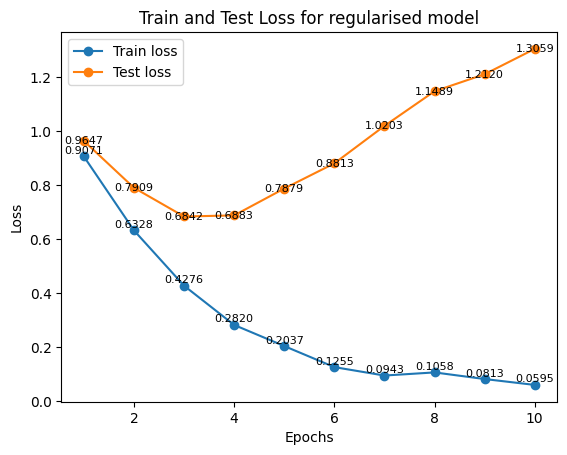

In [9]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

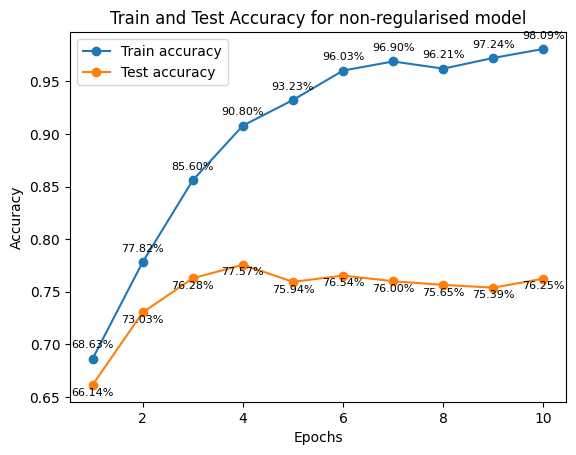

In [10]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### With regularisation and data augmentation applied

In [11]:
train_loader, test_loader = load_cifar10_data(batch_size=64, augmentation=True)

model = NetCIFAR(useRegularization=True).to(device)
epochs = 15 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # L2 regularization with weight_decay
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1:

loss: 2.296013  [   64/50000]
loss: 1.860790  [ 6464/50000]
loss: 1.818361  [12864/50000]
loss: 1.522687  [19264/50000]
loss: 1.441071  [25664/50000]
loss: 1.506106  [32064/50000]
loss: 1.284840  [38464/50000]
loss: 1.406541  [44864/50000]
Train Error: 
 Accuracy: 51.1%, Avg loss: 1.344393 

Test Error: 
 Accuracy: 54.6%, Avg loss: 1.251739 

Epoch 2:

loss: 1.489290  [   64/50000]
loss: 1.164327  [ 6464/50000]
loss: 1.209129  [12864/50000]
loss: 1.287837  [19264/50000]
loss: 1.342305  [25664/50000]
loss: 1.060458  [32064/50000]
loss: 1.246567  [38464/50000]
loss: 1.269855  [44864/50000]
Train Error: 
 Accuracy: 61.8%, Avg loss: 1.058341 

Test Error: 
 Accuracy: 64.7%, Avg loss: 0.991433 

Epoch 3:

loss: 0.995680  [   64/50000]
loss: 1.255345  [ 6464/50000]
loss: 0.964692  [12864/50000]
loss: 1.116888  [19264/50000]
loss: 1.070444  [25664/50000]
loss: 1.166943  [32064/50000]
loss: 0.992747  [38464/5

Plotting metrics

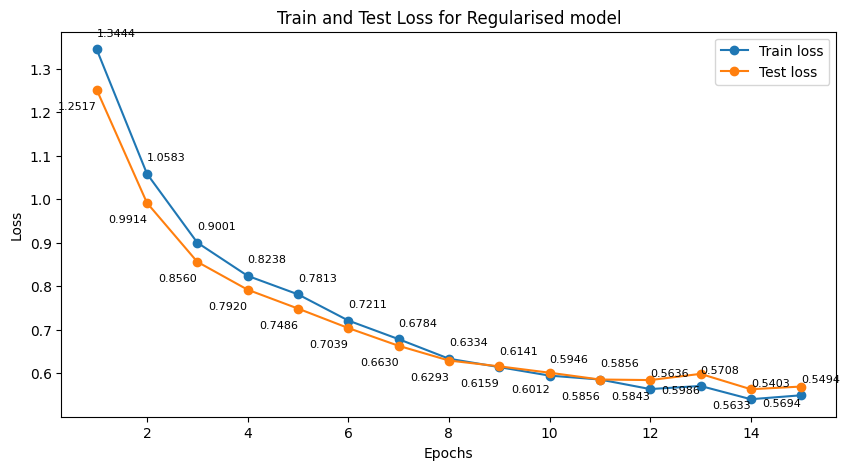

In [12]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

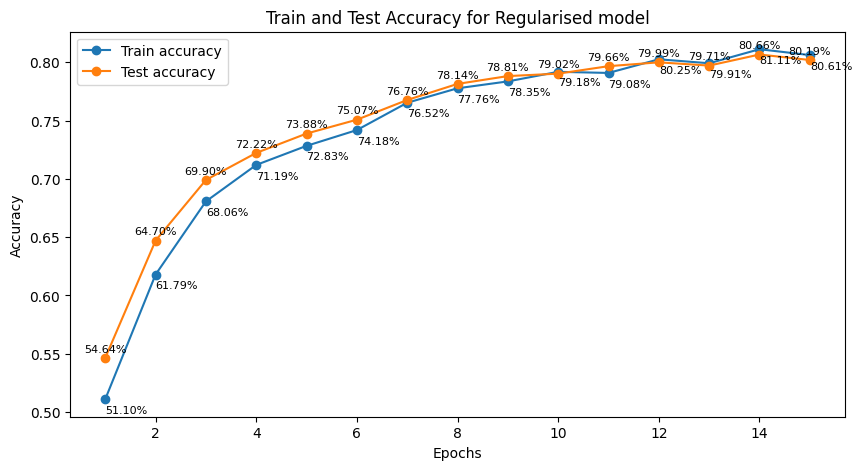

In [13]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Conclusion

**Week 6**: We applied **data augmentation** (random crop, flip) to handle noise or robustify input data, used **Dropout** in the CNN, and included **Weight Decay** in the optimiser. These regularization techniques help reduce overfitting and handle possible noise, aiming for more stable performance.

**End of Week 6 Exercise** – Tweak hyperparams, see if you can push test accuracy further while avoiding overfitting.